In [ ]:
#%matplotlib inline
import kwant
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
from scipy.linalg import eig
import pickle

In [2]:
def eig_biort(h):
    eigvals, eigvecL, eigvecR = eig(h, left=True, right=True)

    norm = eigvecL.conj().T @ eigvecR
    eigvecR = eigvecR @ np.linalg.inv(norm)
    try:
        assert np.allclose(eigvecL.conj().T @ eigvecR, np.eye(h.shape[0]), atol=1e-5), (np.round(eigvecL.conj().T @ eigvecR, 2), np.round(eigvals))
        assert np.allclose(h @ eigvecR, eigvals * eigvecR, atol=1e-5)
        assert np.allclose(h.T.conj() @ eigvecL, eigvals.conj() * eigvecL, atol=1e-5)
    except AssertionError:
        print('Assertion Error')
    return eigvals, eigvecL, eigvecR


In [3]:
lat = kwant.lattice.square(norbs=1)
bulk = kwant.Builder(symmetry=kwant.lattice.TranslationalSymmetry([2,0],[0,2]))

lat_a = kwant.lattice.square(norbs=1)
bulk_a = kwant.Builder(symmetry=kwant.lattice.TranslationalSymmetry([2,0],[0,2]))

In [4]:
#def hopping1_h(site1, site2, t1, t1_dis, seed):
#    return t1 + t1_dis * kwant.digest.gauss(str((site1, site2)), seed)


def onsite(site):
    return 0

def hopping_intra(site1, site2, t1):
    return t1 

def hopping_intrarev(site1, site2, t1):
    return -t1

def hopping_inter(site1, site2, t2):
    return t2

def hopping_interrev(site1, site2, t2):
    return -t2

bulk[lat(0,0)] = onsite
bulk[lat(0,1)] = onsite
bulk[lat(1,1)] = onsite
bulk[lat(1,0)] = onsite
bulk[lat(0,0),lat(0,1)] = hopping_intra
bulk[lat(0,1),lat(1,1)] = hopping_intra
bulk[lat(1,1),lat(1,0)] = hopping_intrarev
bulk[lat(1,0),lat(0,0)] = hopping_intra
bulk[lat(0,1),lat(0,2)] = hopping_inter
bulk[lat(1,0),lat(2,0)] = hopping_inter
bulk[lat(1,1),lat(1,2)] = hopping_interrev
bulk[lat(1,1),lat(2,1)] = hopping_inter

In [5]:
def onsite_a(site,m):
    return 0
##def onsite_arev(site,m):
#    return -m
#
def hopping_intra_a(site1, site2, v1):
    return 1j*v1

def hopping_inter_a(site1, site2, v1):
    return 0

def hopping_intra_arev(site1, site2, v1):
    return -1j*v1


bulk_a[lat_a(0,0)] = onsite_a
bulk_a[lat_a(0,1)] = onsite_a
bulk_a[lat_a(1,1)] = onsite_a
bulk_a[lat_a(1,0)] = onsite_a
bulk_a[lat_a(0,0),lat_a(0,1)] = hopping_intra_a
bulk_a[lat_a(0,1),lat_a(1,1)] = hopping_intra_a
bulk_a[lat_a(1,1),lat_a(1,0)] = hopping_intra_arev
bulk_a[lat_a(1,0),lat_a(0,0)] = hopping_intra_a
bulk_a[lat_a(0,1),lat_a(0,2)] = hopping_inter_a
bulk_a[lat_a(1,0),lat_a(2,0)] = hopping_inter_a
bulk_a[lat_a(1,1),lat_a(1,2)] = hopping_inter_a
bulk_a[lat_a(1,1),lat_a(2,1)] = hopping_inter_a

In [9]:
finite_h = kwant.Builder()
finite_a = kwant.Builder()

L = 10 #ALWAYS CHOOSE ODD NUMBER TO HAVE UNIT CELLS IN EVERY CORNER 

def shape(site):
    x, y = site.pos
    return  -L< x <=L and  -L< y <=L


finite_h.fill(bulk, shape, start=[0,0]);
finite_a.fill(bulk_a, shape, start=[0,0]);

finite_h = finite_h.finalized()
finite_a = finite_a.finalized()



In [ ]:
import kwant
from kwant import wraparound
import numpy as np
import scipy.linalg as la
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
#fig = plt.figure()
#ax = plt.subplot()
kwant.plot(finite_a)
#plt.savefig('/Users/albertozorzato/Desktop/plt/Lattice.pdf')

In [ ]:
seeds = np.arange(0,5,1)
S = []
for seed in seeds:
    params_h1 = dict(t1=0.5, t_c=0, t1_dis=0, t2_dis=0, seed = seed, t2=1.5)
    ham_h1 = finite_h.hamiltonian_submatrix(params = params_h1)
    params_a1 = dict(v1=0.5, m=0)
    ham_a1 = finite_a.hamiltonian_submatrix(params = params_a1)
    ssh = ham_h1 
    evals, evecsL, evecsR = eig_biort(ssh)
    density = kwant.operator.Density(finite_h)
    evecsL = evecsL[:,abs(evals.real)<0.05]
    print(evecsL.shape)
    order = np.argsort(evals.real)
    S.append(evals[order])
S = np.asarray(S)
S = np.mean(S, axis=0)

#plt.rcParams["font.family"] = "serif"
#plt.plot(evals.real[order], 'x', c='m')
#plt.xlabel('Eigenvalues')
#plt.ylabel('Re(E)')

#plt.xlim((590,610))
#plt.ylim((-0.9,0.9))

density0=density(evecsL[:,0])
density1=density(evecsL[:,1])
density2=density(evecsL[:,2])
density3=density(evecsL[:,3])

den = density0+density1+density2+density3
#fig = plt.figure()
#ax = plt.subplot()
kwant.plotter.density(finite_h, den, vmin=0, vmax=1)
#plt.savefig('/Users/albertozorzato/Desktop/plt/clean.pdf', bbox_inches='tight' )

#with open('density_t+.pickle', 'wb') as f:
#    pickle.dump(plot, f)

In [ ]:
plt.plot(evals[np.argsort(evals.real)],'x')
plt.rc('font', family='serif')
plt.xlabel('Eigenvalues')
plt.ylabel('Re(E)')
#plt.xlim((590,610))
#plt.ylim((-0.4,0.4))

In [11]:
Ev = [] 
ts= np.arange(0, 2, 0.1)
for t1 in ts:
    aux = t1
    params_h = dict(t1=aux, t2=1)
    ham_h = finite_h.hamiltonian_submatrix(params = params_h)
    params_a = dict(v1=0.4,m=0)
    ham_a = finite_a.hamiltonian_submatrix(params = params_a)
    hamiltonian = ham_h +1j*ham_a
    evals, evecsL, evecsR  = eig_biort(hamiltonian)
    order = np.argsort(evals.real)                                        
    Ev.append(evals[order])   
    
   

/Users/albertozorzato/anaconda3/envs/sim/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'E')

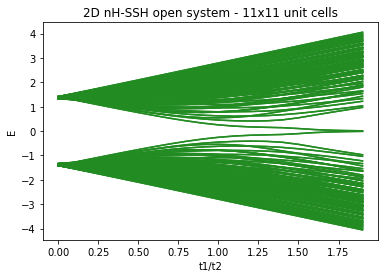

In [12]:
Ev = np.asarray(Ev)
plt.plot(ts, Ev, linewidth=1.5,c='forestgreen')
plt.title("2D nH-SSH open system - 11x11 unit cells")
plt.xlabel('t1/t2')
plt.ylabel('E')
#plt.savefig("/Users/albertozorzato/Desktop/plt/2D SSH spectrum.pdf", bbox_inches='tight')